In [1]:
import fugu
import numpy as np
from fugu import Scaffold
from fugu.bricks.input_bricks import Vector_Input
from fugu.bricks.dense_bricks import dense_layer_1d
from fugu.backends import snn_Backend
import matplotlib.pyplot as plt
import networkx as nx

T = 20

spike_times = [[0]*1 for _ in range(1)]
# neuron 0 spikes at t=3
spike_times[0][2:6] = [1, 1,1,1,1]

print("Input spike times:", spike_times)

W  = np.array([[5.0]])
Th = np.array([0.2])

scaffold = Scaffold()
inp = scaffold.add_brick(
    Vector_Input(
        np.array(spike_times), 
        coding='Raster', 
        name='Input', 
        time_dimension=True), 
        'input',
        output=False,
    )
out = scaffold.add_brick(
    dense_layer_1d(output_shape=(1,), weights=W, thresholds=Th, name='output'),
    input_nodes=[-1], name='output', output=True
)
# scaffold.connect(inp, out)
scaffold.lay_bricks()


print('--- Output Neuron Node Attributes in scaffold.graph ---')
for n, attrs in scaffold.graph.nodes(data=True):
    if 'output' in str(n):
        print(f'Node: {n}, attrs: {attrs}')

backend = snn_Backend()
backend.compile(scaffold, compile_args={'record': 'all', 'debug_mode': True})


# -------------------------------------------------------------------------------
# for key, vals in backend.fugu_circuit.nodes.data():
#     if vals.get('layer') != 'input':
#         continue
#     port = next(iter(vals['ports'].values()))
#     data_ch = port.channels['data']
#     for i, neuron in enumerate(data_ch.neurons):
#         backend.nn.update_input_neuron(neuron, spike_times[i])
# -------------------------------------------------------------------------------

# Run with potentials for visibility
result = backend.run(n_steps=T)

# scaffold.summary()

print(result)



Input spike times: [[0, 1, 1, 1, 1, 1]]
Neuron name in Vector Input: Input-0:(0,)
data.neurons:  ['Input-0:(0,)']
--- Output Neuron Node Attributes in scaffold.graph ---
Node: output_begin, attrs: {'index': -1, 'threshold': 0.0, 'decay': 0.0, 'p': 1.0, 'potential': 0.0, 'brick': 'Brick-1', 'neuron_number': 3}
Node: output_complete, attrs: {'index': 0, 'threshold': 0.9, 'decay': 0.0, 'p': 1.0, 'potential': 0.0, 'brick': 'Brick-1', 'neuron_number': 4}
Node: outputd0, attrs: {'index': np.int64(0), 'threshold': np.float64(0.2), 'decay': 1.0, 'p': 1.0, 'potential': 0.0, 'brick': 'Brick-1', 'neuron_number': 5}
From inside __next__:  []
Input node: 0 Timestep: 0 Spikes: []
From inside __next__:  ['Input-0:(0,)']
Input node: 0 Timestep: 1 Spikes: ['Input-0:(0,)']
From inside __next__:  ['Input-0:(0,)']
Input node: 0 Timestep: 2 Spikes: ['Input-0:(0,)']
From inside __next__:  ['Input-0:(0,)']
Input node: 0 Timestep: 3 Spikes: ['Input-0:(0,)']
From inside __next__:  ['Input-0:(0,)']
Input node: 

In [2]:
print(fugu.__file__)

/Users/kamerongano/Documents/Github/Fugu/fugu/__init__.py


Filtered NetworkX graph nodes:
['Input-0:begin', 'Input-0:complete', 'Input-0:(0,)', 'output_begin', 'output_complete', 'outputd0']
Filtered NetworkX graph edges:
[('Input-0:begin', 'Input-0:complete', {'weight': 1.0, 'delay': 5}), ('Input-0:begin', 'output_begin', {'weight': 0.0, 'delay': 1}), ('Input-0:complete', 'output_complete', {'weight': 0.0, 'delay': 1}), ('Input-0:(0,)', 'outputd0', {'weight': np.float64(5.0), 'delay': 1})]


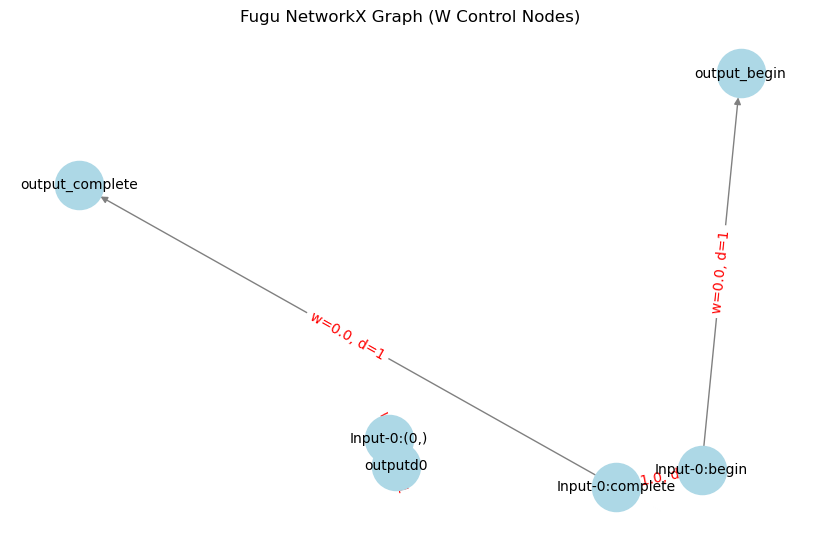

In [3]:
# Print and visualize the networkx graph (excluding control nodes/edges)
def is_control_node(node):
    return isinstance(node, str) and (node.__contains__('begin') or node.__contains__('complete') or node.startswith('control'))

def filter_graph(graph):
    # Remove control nodes and edges
    nodes = [n for n in graph.nodes() if not is_control_node(n)]
    edges = [(u, v) for u, v in graph.edges() if not is_control_node(u) and not is_control_node(v)]
    subgraph = graph.subgraph(nodes).copy()
    return subgraph
# filtered_graph = filter_graph(scaffold.graph)
filtered_graph = scaffold.graph

print('Filtered NetworkX graph nodes:')
print(filtered_graph.nodes())
print('Filtered NetworkX graph edges:')
print(filtered_graph.edges(data=True))
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(filtered_graph)
nx.draw(filtered_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1200, font_size=10)
edge_labels = {(u, v): f'w={d.get("weight")}, d={d.get("delay")}' for u, v, d in filtered_graph.edges(data=True)}
nx.draw_networkx_edge_labels(filtered_graph, pos, edge_labels=edge_labels, font_color='red')
plt.title('Fugu NetworkX Graph (W Control Nodes)')
plt.show()

In [4]:
# Diagnostic: Print backend neuron parameters, input spikes, and output neuron activity
print('--- Backend Output Neuron Parameters ---')
for name, n in backend.nn.nrns.items():
    if name.startswith('outputd'):
        print(f'Neuron: {name}')
        print(f'  threshold: {n.threshold}')
        print(f'  decay/leakage_constant: {getattr(n, "leakage_constant", None)}')
        print(f'  voltage: {getattr(n, "voltage", None)}')
        print(f'  reset_voltage: {getattr(n, "reset_voltage", None)}')
        print(f'  p: {getattr(n, "prob", None)}')

print('\n--- Backend Input Neuron Spikes ---')
for name, n in backend.nn.nrns.items():
    if hasattr(n, 'spikes'):
        print(f'Neuron: {name}, spikes: {getattr(n, "spikes", None)}')

print('\n--- Output Neuron Spike Times and Potentials ---')
st, V = backend.run(n_steps=T, return_potentials=False)
print('Spike times:', st)
print('Potentials:', V)

--- Backend Output Neuron Parameters ---
Neuron: outputd0
  threshold: 0.2
  decay/leakage_constant: 0.0
  voltage: 0.0
  reset_voltage: 0.0
  p: 1.0

--- Backend Input Neuron Spikes ---

--- Output Neuron Spike Times and Potentials ---
Neurons Input-0:(0,) Input-0:begin Input-0:complete output_begin  \
Time                                                               
0             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
1             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
2             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
3             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
4             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
5             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
6             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
7             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
8             (0, 0)      (0, 0.0)         (0, 0.0)     (0, 0.0)   
9             (

In [5]:
# Diagnostic: Print output neuron node attributes from scaffold.graph before backend compile
print('--- Output Neuron Node Attributes in scaffold.graph ---')
for n, attrs in scaffold.graph.nodes(data=True):
    if 'output' in str(n):
        print(f'Node: {n}, attrs: {attrs}')

--- Output Neuron Node Attributes in scaffold.graph ---
Node: output_begin, attrs: {'index': -1, 'threshold': 0.0, 'decay': 0.0, 'p': 1.0, 'potential': 0.0, 'brick': 'Brick-1', 'neuron_number': 3}
Node: output_complete, attrs: {'index': 0, 'threshold': 0.9, 'decay': 0.0, 'p': 1.0, 'potential': 0.0, 'brick': 'Brick-1', 'neuron_number': 4}
Node: outputd0, attrs: {'index': np.int64(0), 'threshold': np.float64(0.2), 'decay': 1.0, 'p': 1.0, 'potential': 0.0, 'brick': 'Brick-1', 'neuron_number': 5}


In [6]:
# Diagnostics for dense_layer_1d compatibility after build and backend compile
print('--- dense_layer_1d Input/Output Coding and Shape ---')
if hasattr(out, 'supported_codings'):
    print('Supported codings:', out.supported_codings)
if hasattr(out, 'metadata'):
    print('Metadata:', out.metadata)
if hasattr(out, 'input_shape'):
    print('Input shape:', out.input_shape)
if hasattr(out, 'output_shape'):
    print('Output shape:', out.output_shape)
print('\n--- dense_layer_1d Neuron Names in Graph ---')
for n in scaffold.graph.nodes():
    if 'output' in str(n):
        print(n)
print('\n--- dense_layer_1d Edge Connections ---')
for u, v, d in scaffold.graph.edges(data=True):
    if 'output' in str(u) or 'output' in str(v):
        print(f'{u} -> {v}, weight={d.get("weight")}, delay={d.get("delay")}')
print('\n--- Backend Output Neuron Mapping and Recording ---')
for name, n in backend.nn.nrns.items():
    if 'output' in name:
        print(f'Neuron: {name}, record: {getattr(n, "record", None)}, threshold: {getattr(n, "threshold", None)}, p: {getattr(n, "p", None)}')

--- dense_layer_1d Input/Output Coding and Shape ---
Supported codings: ['binary-L']
Metadata: {'isNeuralNetworkLayer': True, 'layer_name': 'dense_1d', 'output_shape': (1,), 'input_shape': (1,)}
Input shape: (1,)
Output shape: (1,)

--- dense_layer_1d Neuron Names in Graph ---
output_begin
output_complete
outputd0

--- dense_layer_1d Edge Connections ---
Input-0:begin -> output_begin, weight=0.0, delay=1
Input-0:complete -> output_complete, weight=0.0, delay=1
Input-0:(0,) -> outputd0, weight=5.0, delay=1

--- Backend Output Neuron Mapping and Recording ---
Neuron: output_begin, record: True, threshold: 0.0, p: None
Neuron: output_complete, record: True, threshold: 0.9, p: None
Neuron: outputd0, record: True, threshold: 0.2, p: None
